In [22]:
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
from numpy import cumsum
from statsmodels.tsa.vector_ar.vecm import VECM
from statsmodels.tsa.stattools import adfuller
from matplotlib import style
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
from statsmodels.tsa.vector_ar.vecm import select_coint_rank
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from sklearn.preprocessing import StandardScaler
import pandas as pd
from datetime import datetime, timedelta
import pickle
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.vector_ar.var_model import VAR

In [33]:
df = pd.read_csv('ACB Historical Data.csv')

In [34]:
df

,Date,Price,Open,High,Low,Vol.,Change %
0,12/01/2017,"10,537.7","10,477.8","10,567.6","10,417.9",7.36M,0.86%
1,12/04/2017,"10,926.9","10,537.7","10,956.8","10,537.7",9.45M,3.69%
2,12/05/2017,"10,477.8","10,956.8","10,956.8","10,477.8",8.19M,-4.11%
3,12/06/2017,"10,447.9","10,447.9","10,627.5","10,328.1",9.81M,-0.29%
4,12/07/2017,"10,837.1","10,447.9","10,837.1","10,447.9",8.30M,3.73%
...,...,...,...,...,...,...,...
1341,04/24/2023,"24,200.0","24,300.0","24,450.0","24,100.0",2.27M,-0.21%
1342,04/25/2023,"24,150.0","24,300.0","24,450.0","24,100.0",6.17M,-0.21%
1343,04/26/2023,"24,150.0","24,150.0","24,200.0","23,950.0",3.86M,0.00%
1344,04/27/2023,"24,150.0","24,200.0","24,450.0","24,100.0",2.18M,0.00%


In [35]:
# Hàm chuyển đổi "Vol." từ chuỗi sang số
def convert_volume_to_number(volume_str):
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return int(volume_str)
    
# Hàm chuyển đổi "Change %" từ chuỗi sang số
def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%')) / 100
    return new_change

# Hàm chuyển giá từ chuỗi sang số
def convert_str_to_number(str):
    return float(str.replace(',', ''))

In [36]:
# Áp dụng hàm chuyển đổi cho cột "Vol."
df["Vol."] = df["Vol."].apply(convert_volume_to_number)

# Áp dụng hàm chuyển đổi cho cột "Change %"
df["Change %"] = df["Change %"].apply(convert_change_to_number)

# Áp dụng hàm chuyển đổi cho các cột giá trị
df['Price'] = df['Price'].apply(convert_str_to_number)
df['Open'] = df['Open'].apply(convert_str_to_number)
df['High'] = df['High'].apply(convert_str_to_number)
df['Low'] = df['Low'].apply(convert_str_to_number)

In [37]:
data = df

In [38]:
data


,Date,Price,Open,High,Low,Vol.,Change %
0,12/01/2017,10537.7,10477.8,10567.6,10417.9,7360000,0.0086
1,12/04/2017,10926.9,10537.7,10956.8,10537.7,9450000,0.0369
2,12/05/2017,10477.8,10956.8,10956.8,10477.8,8189999,-0.0411
3,12/06/2017,10447.9,10447.9,10627.5,10328.1,9810000,-0.0029
4,12/07/2017,10837.1,10447.9,10837.1,10447.9,8300000,0.0373
...,...,...,...,...,...,...,...
1341,04/24/2023,24200.0,24300.0,24450.0,24100.0,2270000,-0.0021
1342,04/25/2023,24150.0,24300.0,24450.0,24100.0,6170000,-0.0021
1343,04/26/2023,24150.0,24150.0,24200.0,23950.0,3860000,0.0000
1344,04/27/2023,24150.0,24200.0,24450.0,24100.0,2180000,0.0000


In [39]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, GlobalAveragePooling1D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [40]:
# Chuẩn hóa dữ liệu
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data[['Price']])

In [41]:
scaled_data

array([[-1.08379681],
       [-1.02296767],
       [-1.09315875],
       ...,
       [ 1.04370704],
       [ 1.04370704],
       [ 1.05152168]])

In [42]:
# Chia dữ liệu thành tập train, test, validate
train_data = scaled_data[:int(len(scaled_data)*0.7)]
test_data = scaled_data[int(len(scaled_data)*0.7):]
train_seq = TimeseriesGenerator(train_data, train_data, length=30, batch_size=32)
test_seq = TimeseriesGenerator(test_data, test_data, length=30, batch_size=32)


In [43]:
# Xây dựng mô hình Inception Time
input_layer = Input(shape=(30, 1))

conv1 = Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(input_layer)
conv2 = Conv1D(filters=32, kernel_size=5, activation='relu', padding='same')(input_layer)
conv3 = Conv1D(filters=32, kernel_size=7, activation='relu', padding='same')(input_layer)
concat = concatenate([conv1, conv2, conv3], axis=2)

pooling = MaxPooling1D(pool_size=2)(concat)

conv4 = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(pooling)
conv5 = Conv1D(filters=64, kernel_size=5, activation='relu', padding='same')(pooling)
conv6 = Conv1D(filters=64, kernel_size=7, activation='relu', padding='same')(pooling)
concat2 = concatenate([conv4, conv5, conv6], axis=2)

pooling2 = MaxPooling1D(pool_size=2)(concat2)

conv7 = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(pooling2)
conv8 = Conv1D(filters=128, kernel_size=5, activation='relu', padding='same')(pooling2)
conv9 = Conv1D(filters=128, kernel_size=7, activation='relu', padding='same')(pooling2)
concat3 = concatenate([conv7, conv8, conv9], axis=2)

global_pooling = GlobalAveragePooling1D()(concat3)

output_layer = Dense(1, activation='linear')(global_pooling)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='mse')

In [44]:
# Huấn luyện mô hình
early_stop = EarlyStopping(monitor='val_loss', patience=10)
model.fit(train_seq, validation_data=test_seq, epochs=100, callbacks=[early_stop])


Epoch 1/100
29/29 [==============================] - 3s 23ms/step - loss: 0.2539 - val_loss: 0.2124
Epoch 2/100
29/29 [==============================] - 0s 15ms/step - loss: 0.0388 - val_loss: 0.0431
Epoch 3/100
29/29 [==============================] - 0s 15ms/step - loss: 0.0839 - val_loss: 0.8503
Epoch 4/100
29/29 [==============================] - 0s 15ms/step - loss: 0.1692 - val_loss: 0.1109
Epoch 5/100
29/29 [==============================] - 0s 14ms/step - loss: 0.0283 - val_loss: 0.0328
Epoch 6/100
29/29 [==============================] - 0s 14ms/step - loss: 0.0426 - val_loss: 0.0345
Epoch 7/100
29/29 [==============================] - 0s 14ms/step - loss: 0.0374 - val_loss: 0.0413
Epoch 8/100
29/29 [==============================] - 0s 16ms/step - loss: 0.0270 - val_loss: 0.0415
Epoch 9/100
29/29 [==============================] - 0s 14ms/step - loss: 0.0290 - val_loss: 0.0310
Epoch 10/100
29/29 [==============================] - 0s 14ms/step - loss: 0.0298 - val_loss: 0.0324

In [45]:
# Dự báo giá cổ phiếu trên tập test
predicted_values = model.predict(test_seq)

12/12 [==============================] - 0s 4ms/step


In [46]:
# Chuyển trở lại đơn vị ban đầu
predicted_values = scaler.inverse_transform(predicted_values)
test_data = scaler.inverse_transform(test_data)


In [47]:
# In ra kết quả
print(predicted_values)

[[25635.9  ]
 [26000.453]
 [26103.635]
 [26281.688]
 [26560.412]
 [26551.857]
 [26599.896]
 [26608.031]
 [26603.154]
 [26593.42 ]
 [26508.1  ]
 [26553.15 ]
 [26573.861]
 [26543.307]
 [26582.521]
 [26407.604]
 [26538.787]
 [26787.35 ]
 [26865.318]
 [27306.918]
 [27427.69 ]
 [27385.615]
 [27310.498]
 [26973.045]
 [26900.125]
 [26792.979]
 [26627.346]
 [26496.467]
 [26579.936]
 [26617.744]
 [26786.295]
 [26898.332]
 [26953.72 ]
 [26913.861]
 [26965.998]
 [26882.426]
 [26902.56 ]
 [26844.34 ]
 [26767.469]
 [26712.602]
 [26616.441]
 [26637.773]
 [26715.33 ]
 [26877.057]
 [27001.13 ]
 [27028.89 ]
 [27210.707]
 [27263.814]
 [27133.266]
 [27067.922]
 [26885.81 ]
 [26742.176]
 [26637.209]
 [26619.793]
 [26696.09 ]
 [26695.322]
 [26630.389]
 [26605.762]
 [26604.566]
 [26638.69 ]
 [26781.379]
 [27075.936]
 [27320.848]
 [27617.264]
 [27630.965]
 [27546.012]
 [27515.553]
 [27731.172]
 [27843.123]
 [27936.096]
 [27998.336]
 [27559.16 ]
 [27489.44 ]
 [27368.848]
 [27352.846]
 [27322.988]
 [27405.875]

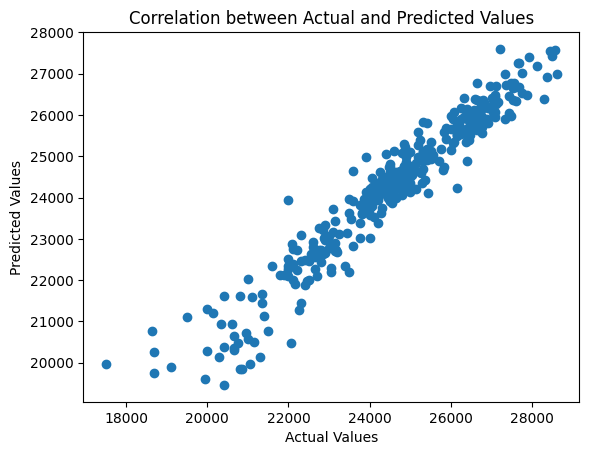

In [19]:
# Vẽ đồ thị tương quan giữa giá trị dự đoán và giá trị thực
plt.scatter(test_data[30:, 0], predicted_values[:, 0])
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Correlation between Actual and Predicted Values')
plt.show()

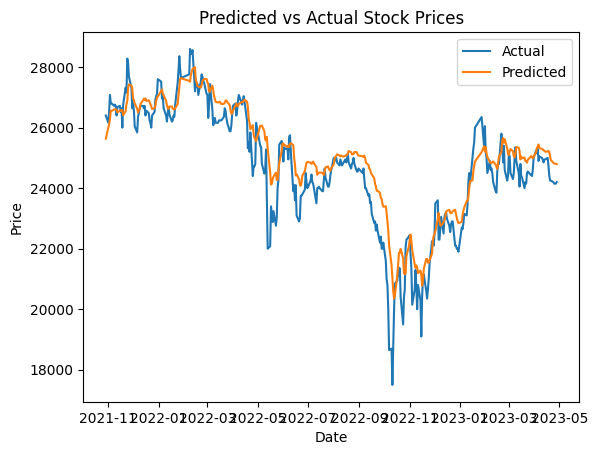

In [49]:
import matplotlib.pyplot as plt

# Chuyển định dạng ngày tháng sang Timestamp
dates = pd.to_datetime(data['Date'])
test_dates = dates[int(len(dates)*0.7) + 30:]

# Vẽ đồ thị giá trị thực
plt.plot(test_dates, test_data[30:, 0], label='Actual')

# Vẽ đồ thị giá trị dự đoán
plt.plot(test_dates, predicted_values[:, 0], label='Predicted')

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Predicted vs Actual Stock Prices')
plt.legend()
plt.show()

In [52]:

# Calculate the root mean squared error (RMSE) of the predictions
rmse = np.sqrt(np.mean((test_data[30:, 0] - predicted_values[:, 0])**2))
print('RMSE:', rmse)

# Calculate the mean absolute percentage error (MAPE) of the predictions
mape = np.mean(np.abs((test_data[30:, 0] - predicted_values[:, 0]) / predicted_values[:, 0])) * 100
print('MAPE:', mape)

# Calculate the mean absolute error (MAE) of the predictions
mae = np.mean(np.abs(test_data[30:, 0] - predicted_values[:, 0]))
print('MAE:', mae)

RMSE: 804.0145259114789
MAPE: 2.444859538773336
MAE: 597.588663519385
